In [1]:
import os
import re
from nltk import pos_tag, RegexpParser
import pandas as pd
import numpy as np
a_ids = []
e_ids = []


for filename in os.listdir("annotations_ground_truth/pool"):
    if filename[0] != ".": 
        filename_num = re.findall(r"_\d+\.?\d*.",filename)
        if len(filename_num)>0:
            num = re.findall(r"\d+\d*",filename_num[0])
#             print(num)
            e_ids.append(int(num[0]))

for i in e_ids:
    for filename in os.listdir("train.test.released.8.17.09"):
        if filename[0] != ".":
#             b_ids.append(int(filename))
            if(i==int(filename)):
                a_ids.append(int(filename))
                break



# build annotation and entry corpora

a_corpus = []
e_corpus = []

for file in sorted(a_ids):
    path = "train.test.released.8.17.09/" + str(file)
    with open(path) as f:
        content = f.read().splitlines()
        e_corpus.append(content)
    num = ''
    for filename in os.listdir("annotations_ground_truth/converted.noduplicates.sorted"):
        if filename[0] != ".": 
            filename_num = re.findall(r"_\d+\.?\d*.",filename)
            if len(filename_num)>0:
                num = re.findall(r"\d+\d*",filename_num[0])
                if(int(num[0])==file):
                    path = "annotations_ground_truth/converted.noduplicates.sorted/" + str(filename)
                    with open(path) as f:
        #content = f.readlines()
                        content = f.read().splitlines()
                        a_corpus.append(content)
#  ["id", "row", "offset", "word", "POS", "chunk", "NER"]
entries_cols = ['sentence_row',"id", "row", "offset", "word"]
entries_df = pd.DataFrame(columns=entries_cols)
annotations_cols = ["id", "NER_tag", "row", "offset", "length"]
annotations_df = pd.DataFrame(columns=annotations_cols)

annotations_df = pd.DataFrame(columns=annotations_cols)  # reset df

In [2]:
a_ids = sorted(a_ids)
e_ids = sorted(e_ids)

In [3]:
def transAnnotation(corpus):
    tmp_list = []
    annotations_df = pd.DataFrame(columns=annotations_cols)
    for i, document in enumerate(corpus):

        for row in document:
            row = row.split("||")
            # print(row, "\n")

            for tag in row: 
                tag = tag.split("=")
                if ":" in tag[1]:
                    tag_label = tag[0].lstrip(" ")
                    tag_row_a = tag[1].split(" ")[-2:][0].split(":")[0]
                    tag_row_b = tag[1].split(" ")[-2:][1].split(":")[0]

                    # some annotations have non-standard formatting (losing 64 instances)
                    try:
                        tag_offset_a = int(tag[1].split(" ")[-2:][0].split(":")[1])
                        tag_offset_b = int(tag[1].split(" ")[-2:][1].split(":")[1])
                        length = tag_offset_b - tag_offset_a + 1

                        # 1 row = 1 token with a tag
                        first = True
                        BIO_tag = "B-"
                        if length > 1 and tag_row_a == tag_row_b:
                            for offset in range(tag_offset_a, tag_offset_b+1):
                                if first: 
                                    tag_label = BIO_tag + tag_label
                                    first = False
                                else:
                                    tag_label = tag_label.replace("B-", "I-")
                                tmp_list.append([a_ids[i], tag_label, tag_row_a, offset, 1])
                        # TODO: tags over line breaks
                        else:
                            tmp_list.append([a_ids[i], BIO_tag + tag_label, tag_row_a, tag_offset_a, length])
                    except:
                        pass             

    annotations_df = pd.DataFrame(tmp_list, columns=annotations_cols)
    annotations_df.reset_index(inplace=True)
    annotations_df = annotations_df.drop(columns=["index", "length"])
    return annotations_df

In [4]:
# data split
train = 178
dev = 216
train_a_corpus = a_corpus[:train]
dev_a_corpus = a_corpus[train:dev]
test_a_corpus = a_corpus[dev:]

train_e_corpus = e_corpus[:train]
dev_e_corpus = e_corpus[train:dev]
test_e_corpus = e_corpus[dev:]

In [5]:

train_annotations_df = transAnnotation(train_a_corpus)
test_annotations_df = transAnnotation(test_a_corpus)
dev_annotations_df = transAnnotation(dev_a_corpus)

In [6]:
def transEntity(corpus):
    entries_df = pd.DataFrame(columns=entries_cols)  # reset df
    tmp_list = []
    senten_row = 0
    for doc_i, document in enumerate(corpus):

#         tmp_list.append([0, 0, 0, "-DOCSTART-"])
#         tmp_list.append([0, 0, 0, "-EMPTYLINE-"])

        for row_i, row in enumerate(document):
            row_split = row.split(" ")
            senten_row+=1
            for word_i, word in enumerate(row_split):
#                 word = word.rstrip(".")  # strip "." from end of word
                word = word.replace("\t", "")
                word_id = a_ids[doc_i]
                word_row = row_i+1  # 1-based indexing 
                word_offset = word_i # 0-based indexing
                
                if len(word) > 0 and "|" not in word:
                    tmp_list.append([senten_row,word_id, word_row, word_offset, word])

#         tmp_list.append([0, 0, 0, "-EMPTYLINE-"])

    entries_df = pd.DataFrame(tmp_list, columns=entries_cols)
    return entries_df

In [7]:
train_entries_df = transEntity(train_e_corpus)
test_entries_df = transEntity(test_e_corpus)
dev_entries_df = transEntity(dev_e_corpus)

In [8]:
def normalize_a(df):
    df[['id', 'row', 'offset']] = df[['id', 'row', 'offset']].apply(pd.to_numeric)
    df['NER_tag'] = df["NER_tag"].astype(str)
    return df
def normalize_e(df):
    df[['sentence_row','id', 'row', 'offset']] = df[['sentence_row','id', 'row', 'offset']].apply(pd.to_numeric)
    df["word"] = df["word"].astype(str)
    return df

train_annotations_df = normalize_a(train_annotations_df)
test_annotations_df = normalize_a(test_annotations_df)
dev_annotations_df = normalize_a(dev_annotations_df)

train_entries_df = normalize_e(train_entries_df)
test_entries_df = normalize_e(test_entries_df)
dev_entries_df = normalize_e(dev_entries_df)

In [9]:
train_result_df = pd.merge(train_entries_df, train_annotations_df, how="left", on=['id', 'row', 'offset'])
test_result_df = pd.merge(test_entries_df, test_annotations_df, how="left", on=['id', 'row', 'offset'])
dev_result_df = pd.merge(dev_entries_df, dev_annotations_df, how="left", on=['id', 'row', 'offset'])

In [10]:
train_entries_df[1200:1250]


,sentence_row,id,row,offset,word
1200,148,661,148,8,The
1201,148,661,148,9,diet
1202,149,661,149,0,guidelines
1203,149,661,149,1,will
1204,149,661,149,2,be
1205,149,661,149,3,coordinated
1206,149,661,149,4,by
1207,149,661,149,5,the
1208,149,661,149,6,staff
1209,149,661,149,7,at


In [11]:
train_result_df = train_result_df.drop(columns=["id", "offset","row"])
test_result_df = test_result_df.drop(columns=["id", "offset","row"])
dev_result_df = dev_result_df.drop(columns=["id", "offset","row"])

In [12]:
# train_result_df[0:50]

In [13]:
dev_result_df_ori = dev_result_df
train_result_df_ori = train_result_df
test_result_df_ori = test_result_df

train_result_df=train_result_df.fillna(value={'NER_tag':'o'})
test_result_df=test_result_df.fillna(value={'NER_tag':'o'})
dev_result_df=dev_result_df.fillna(value={'NER_tag':'o'})

In [14]:
# train_result_df[50:100]

In [15]:
import spacy
from spacy import displacy
from spacy.tokenizer import Tokenizer
# nlp = spacy.load('en_core_web_sm')
# nlp.max_length = 1700000
# text = train_result_df["word"].tolist()
# doc = nlp(' '.join(text), disable = ['ner', 'parser'])
def adding_pos(df):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 1700000
    nlp.tokenizer = Tokenizer(nlp.vocab, token_match=re.compile(r'\S+').match)
    text = df["word"].tolist()
    doc = nlp(' '.join(text), disable = ['ner', 'parser'])
    pos_lis = []
    for token in doc:
        pos_lis.append(token.pos_)
    df["POS"] = pos_lis
    return df

In [16]:
# 

In [17]:
train_result_df = adding_pos(train_result_df)
test_result_df = adding_pos(test_result_df)
dev_result_df = adding_pos(dev_result_df)

/Users/brian/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/brian/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0 and may not be 100% compatible with the current version (3.2.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/brian/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:833: UserWarning: [W095] Mo

In [18]:
# train_result_df[50:100]

In [19]:
train_result_df = train_result_df[['sentence_row', 'word', 'POS', 'NER_tag']].astype(str)
test_result_df = test_result_df[['sentence_row', 'word', 'POS', 'NER_tag']].astype(str)
dev_result_df = dev_result_df[['sentence_row', 'word', 'POS', 'NER_tag']].astype(str)

In [20]:
train_result_df

,sentence_row,word,POS,NER_tag
0,1,RECORD,NOUN,o
1,1,#661,NUM,o
2,2,753455514,NUM,o
3,2,ACH,PROPN,o
4,2,15453858,NUM,o
...,...,...,...,...
203917,23707,D:,NOUN,o
203918,23707,5/18/98,NUM,o
203919,23708,T:,NOUN,o
203920,23708,8/21/98,PROPN,o


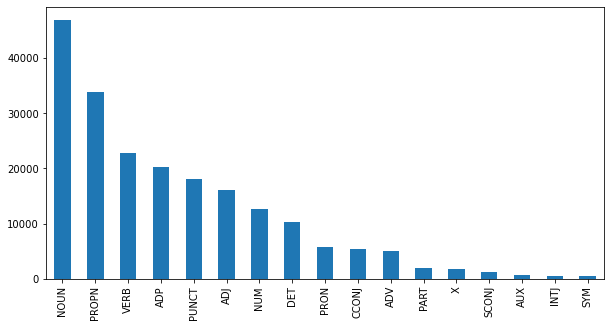

In [21]:
train_result_df["POS"].value_counts().plot(kind="bar", figsize=(10,5));

<AxesSubplot:>

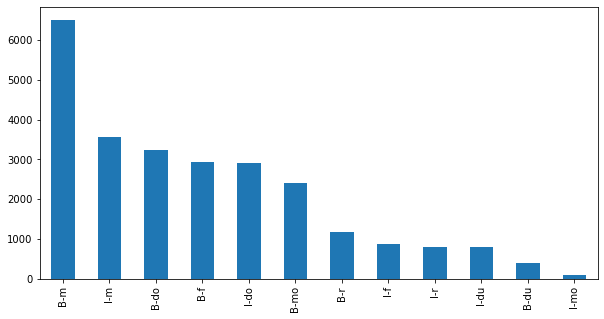

In [22]:
train_result_df[train_result_df["NER_tag"]!="o"]["NER_tag"].value_counts().plot(kind="bar", figsize=(10,5))

In [23]:
from spacy.lang.en import English
from spacy.pipeline import Sentencizer

In [24]:
nlp = English()

# Create a sentence segmentation component. 
sentencizer = Sentencizer()

# Add the component to the pipeline.
nlp.add_pipe('sentencizer')
nlp.max_length = 1700000
text = ' '.join(train_result_df["word"].tolist())


# The following line applies the pipeline (so far only sentence segmentation) on the given text, and stores the result in doc.
annotations = nlp(text)

# Check the result of sentence segmentation.
sents_list = []
for sent in annotations.sents:
    #The following line adds a tuple with 3 elements representing a sentence: the start offset, end offset and text
    sents_list.append((sent.start_char, sent.end_char, sent.text.strip()))
# for sent in sents_list:
#     print(sent)

In [25]:
len(sents_list)

13522

In [26]:
def to_tuples(df):
    iterator = zip(df["word"].values.tolist(),
                   df["POS"].values.tolist(),
                   df["NER_tag"].values.tolist())
    return [(word, pos, tag) for word, pos, tag in iterator]

In [27]:
df_data=pd.concat([train_result_df, test_result_df])

In [28]:
# train_tuples = to_tuples(train_result_df)
# test_tuples = to_tuples(test_result_df)
# dev_tuples = to_tuples(dev_result_df)

In [29]:
rows_train = df_data.groupby("sentence_row").apply(to_tuples).tolist()

In [30]:
len(rows_train)

23500

In [51]:
X = [[word[0] for word in sentence] for sentence in rows_train]
y = [[word[2] for word in sentence] for sentence in rows_train]

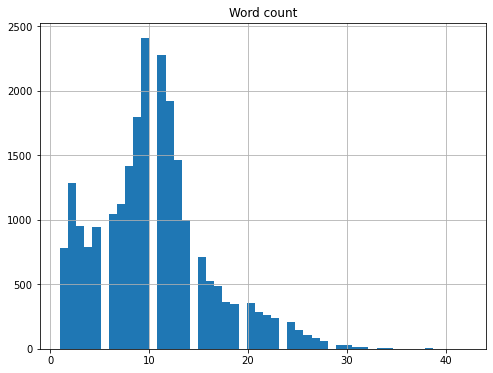

In [52]:
word_counts = df_data.groupby("sentence_row")["word"].agg(["count"])
word_counts = word_counts.rename(columns={"count": "Word count"})
word_counts.hist(bins=50, figsize=(8,6));

In [53]:
MAX_SENTENCE = word_counts.max()[0]

In [54]:
all_words = list(set(df_data["word"].values))
all_tags = list(set(df_data["NER_tag"].values))

In [55]:
word2index = {word: idx + 2 for idx, word in enumerate(all_words)}

word2index["--UNKNOWN_WORD--"]=0

word2index["--PADDING--"]=1

index2word = {idx: word for word, idx in word2index.items()}

In [36]:
import pickle
import operator
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
# from keras_contrib.utils import save_load_utils

from keras import layers
from keras import optimizers

from keras.models import Model
# from keras.models import Input

from keras_contrib.layers import CRF
from keras_contrib import losses
from keras_contrib import metrics
# for k,v in sorted(word2index.items(), key=operator.itemgetter(1))[:10]:
#     print(k,v)

Using TensorFlow backend.


In [56]:
tag2index = {tag: idx + 1 for idx, tag in enumerate(all_tags)}
tag2index["--PADDING--"] = 0

index2tag = {idx: word for word, idx in tag2index.items()}

In [57]:
X = [[word2index[word] for word in sentence] for sentence in X]
y = [[tag2index[tag] for tag in sentence] for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [10116, 21789, 10116, 13746]
y[0]: [12, 12, 12, 12]


In [58]:
X = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X]
y = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y]
print("X[0]:", X[0])
print("y[0]:", y[0])

X[0]: [10116, 21789, 10116, 13746, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
y[0]: [12, 12, 12, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [59]:
# TAG_COUNT = len(tag2index)
# y = [ np.eye(TAG_COUNT)[sentence] for sentence in y]
# y[0]

In [60]:
tags = list(set(train_result_df["NER_tag"].values))
print("Tags:", tags)
n_tags = len(tags)

Tags: ['I-do', 'B-m', 'I-f', 'I-m', 'B-du', 'I-r', 'I-du', 'B-r', 'I-mo', 'B-do', 'B-mo', 'o', 'B-f']


In [61]:
from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [ ]:
# rows_test = test_result_df.groupby("sentence_row").apply(to_tuples).tolist()
# X_test = [[word[0] for word in sentence] for sentence in rows_test]
# y_test = [[word[2] for word in sentence] for sentence in rows_test]

# X_test = [[word2index[word] for word in sentence] for sentence in X_test]
# y_test = [[tag2index[tag] for tag in sentence] for sentence in y_test]

# X_test = [sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in X_test]
# y_test = [sentence + [tag2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence)) for sentence in y_test]

# y_test = [ np.eye(TAG_COUNT)[sentence] for sentence in y_test]

In [63]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [43]:
WORD_COUNT = len(index2word)
DENSE_EMBEDDING = 50
LSTM_UNITS = 50
LSTM_DROPOUT = 0.1
DENSE_UNITS = 100
BATCH_SIZE = 256
MAX_EPOCHS = 10

In [44]:
input_layer = layers.Input(shape=(MAX_SENTENCE,))

model = layers.Embedding(WORD_COUNT, DENSE_EMBEDDING, embeddings_initializer="uniform", input_length=MAX_SENTENCE)(input_layer)

model = layers.Bidirectional(layers.LSTM(LSTM_UNITS, recurrent_dropout=LSTM_DROPOUT, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(DENSE_UNITS, activation="relu"))(model)

crf_layer = CRF(units=TAG_COUNT)
output_layer = crf_layer(model)

ner_model = Model(input_layer, output_layer)

loss = losses.crf_loss
acc_metric = metrics.crf_accuracy
opt = optimizers.Adam(lr=0.001)

ner_model.compile(optimizer=opt, loss=loss, metrics=[acc_metric])

ner_model.summary()

2022-07-26 06:57:57.526742: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-07-26 06:57:57.583819: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb6fc8df700 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-26 06:57:57.583844: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 42)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 42, 50)            1240050   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 42, 100)           40400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 42, 100)           10100     
_________________________________________________________________
crf_1 (CRF)                  (None, 42, 14)            1638      
Total params: 1,292,188
Trainable params: 1,292,188
Non-trainable params: 0
_________________________________________________________________


In [45]:
#model structure

In [64]:
history = ner_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=MAX_EPOCHS, validation_split=0.1, verbose=2)

Train on 17977 samples, validate on 1998 samples
Epoch 1/10
 - 19s - loss: 0.0305 - crf_accuracy: 0.9899 - val_loss: 0.0663 - val_crf_accuracy: 0.9861
Epoch 2/10
 - 20s - loss: 0.0259 - crf_accuracy: 0.9906 - val_loss: 0.0624 - val_crf_accuracy: 0.9862
Epoch 3/10
 - 24s - loss: 0.0222 - crf_accuracy: 0.9914 - val_loss: 0.0642 - val_crf_accuracy: 0.9869
Epoch 4/10
 - 23s - loss: 0.0186 - crf_accuracy: 0.9923 - val_loss: 0.0641 - val_crf_accuracy: 0.9870
Epoch 5/10
 - 23s - loss: 0.0155 - crf_accuracy: 0.9929 - val_loss: 0.0633 - val_crf_accuracy: 0.9872
Epoch 6/10
 - 22s - loss: 0.0128 - crf_accuracy: 0.9935 - val_loss: 0.0630 - val_crf_accuracy: 0.9871
Epoch 7/10
 - 24s - loss: 0.0101 - crf_accuracy: 0.9940 - val_loss: 0.0636 - val_crf_accuracy: 0.9875
Epoch 8/10
 - 34s - loss: 0.0080 - crf_accuracy: 0.9944 - val_loss: 0.0653 - val_crf_accuracy: 0.9870
Epoch 9/10
 - 21s - loss: 0.0063 - crf_accuracy: 0.9947 - val_loss: 0.0633 - val_crf_accuracy: 0.9870
Epoch 10/10
 - 21s - loss: 0.0042

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'CRF Accuracy'}, xlabel='Epochs', ylabel='CRF Accuracy'>],
       dtype=object))

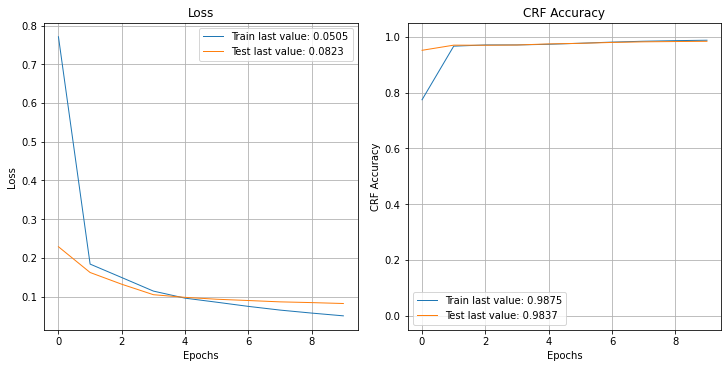

In [54]:
plot_history(history.history)

In [66]:
# Eval
pred_cat = ner_model.predict(X_test)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_test, -1)



{2: '9/1/2000',
 3: 'placement.',
 4: 'vaso',
 5: '7-10',
 6: 'neighbor',
 7: 'Damms',
 8: 'Override',
 9: '7/13/2004',
 10: 'orthostatic',
 11: '+pn',
 12: 'Given',
 13: 'consult-',
 14: 'SARNA',
 15: 'JARROD',
 16: 'follows.',
 17: '105',
 18: '969014',
 19: '89%',
 20: 'x5',
 21: '7/13/06',
 22: 'Stolberg',
 23: 'soft',
 24: 'Pain:',
 25: '03417627',
 26: 'Ciprofloxacin',
 27: 'gestation',
 28: 'distension.',
 29: 'ZETIA',
 30: 'XX29',
 31: '23;',
 32: '41.8',
 33: 'intracranial',
 34: 'occa-',
 35: 'GUENIN',
 36: 'Allopurinol',
 37: 'SEBASTIAN',
 38: '389',
 39: 'HEADACHE.',
 40: 'TV',
 41: '0/25/95',
 42: '1bilateral',
 43: 'DID',
 44: 'SECONDARY',
 45: 'Supratherapeutic',
 46: '14-french',
 47: '1/28/2006',
 48: 'SPEP',
 49: 'clinic',
 50: 'DEMARIO',
 51: 'Acebutolol.',
 52: 'NYHA',
 53: 'Szesterniak',
 54: 'O2',
 55: 'ACETATE',
 56: 'regained',
 57: 'p.m.;',
 58: '*HTN:',
 59: '7/8/05',
 60: '180',
 61: 'EMH',
 62: 'LOZENGE',
 63: 'Strep',
 64: 'set',
 65: 'REGES',
 66: 'RPR',
 

In [93]:
from sklearn_crfsuite.metrics import flat_classification_report
# Convert the index to tag
pred_tag = [[index2tag[i] for i in row] for row in pred]
y_te_true_tag = [[index2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

TypeError: classification_report() takes 2 positional arguments but 3 were given

In [94]:
from sklearn import metrics
        
# print(metrics.classification_report(y_te_true_tag, pred_tag,labels=index2tag))
metrics.confusion_matrix(y_te_true_tag, pred_tag)

ValueError: multiclass-multioutput is not supported

In [79]:
index2tag

{1: 'I-do',
 2: 'B-m',
 3: 'I-f',
 4: 'I-m',
 5: 'B-du',
 6: 'I-r',
 7: 'I-du',
 8: 'B-r',
 9: 'I-mo',
 10: 'B-do',
 11: 'B-mo',
 12: 'o',
 13: 'B-f',
 0: '--PADDING--'}

In [53]:
# sentence = "HCTZ 50 mg p.o. q.d. , enteric-coated aspirin 325 mg"

sentence = "She is given Fragmin 5000 units subcutaneously daily, Lantus 40 units subcutaneously at bedtime, OxyContin 30 mg p.o. q.12 h., folic acid 1 mg daily, levothyroxine 0.1 mg p.o. daily"

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")
sentence = re_tok.sub(r"", sentence).split()

padded_sentence = sentence + [word2index["--PADDING--"]] * (MAX_SENTENCE - len(sentence))
padded_sentence = [word2index.get(w, 0) for w in padded_sentence]

pred = ner_model.predict(np.array([padded_sentence]))
pred = np.argmax(pred, axis=-1)

retval = ""
for w, p in zip(sentence, pred[0]):
    retval = retval + "{:15}: {:5}".format(w, index2tag[p]) + "\n"
print(retval)

She            : o    
is             : o    
given          : o    
Fragmin        : o    
5000           : B-do 
units          : I-do 
subcutaneously : B-mo 
daily          : B-f  
Lantus         : I-m  
40             : B-do 
units          : I-do 
subcutaneously : B-mo 
at             : o    
bedtime        : o    
OxyContin      : B-m  
30             : B-do 
mg             : I-do 
po             : B-f  
q12            : o    
h              : o    
folic          : B-m  
acid           : I-m  
1              : B-do 
mg             : I-do 
daily          : B-f  
levothyroxine  : I-m  
01             : B-do 
mg             : I-do 
po             : B-mo 
daily          : B-f  



In [52]:
ner_model.predict

In [91]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [48]:
Y_test_pred = ner_model.predict(X_train)

In [88]:
len(y_te_true_tag)

3525

In [109]:
cm = confusion_matrix(np.array(y_true_), np.array(pred))

<AxesSubplot:>

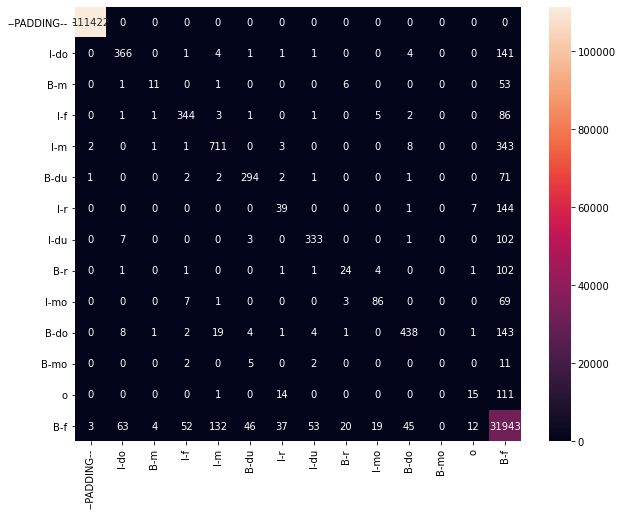

In [111]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])


In [96]:
print(f'Test:\n{classification_report(np.array(y_te_true_tag), pred_tag, target_names=index2tag)}')

ValueError: multiclass-multioutput is not supported

In [97]:
np.save('true.csv',np.array(y_te_true_tag))

In [98]:
np.save('pre.csv',np.array(pred_tag))

In [103]:
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
print(y_te_true_tag)

[['o', 'o', 'o', 'B-m', 'I-m', 'o', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--'], ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADDING--', '--PADD

In [105]:
target_names = ['--PADDING--', 'I-do', 'B-m','I-f','I-m','B-du','I-r','I-du','B-r','I-mo','B-do','B-mo','o','B-f']
print(classification_report(y_te_true_tag, pred_tag, target_names=target_names))

ValueError: multiclass-multioutput is not supported

[['o',
  'o',
  'o',
  'B-m',
  'I-m',
  'o',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--'],
 ['o',
  'o',
  'o',
  'o',
  'o',
  'o',
  'o',
  'o',
  'o',
  'o',
  'o',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADDING--',
  '--PADD

In [107]:
import operator
from functools import reduce
pred = reduce(operator.add, pred_tag)
y_true_ = reduce(operator.add, y_te_true_tag)

In [116]:
print(classification_report(y_true_, pred,digits=4,zero_division=0))

              precision    recall  f1-score   support

 --PADDING--     0.9999    1.0000    1.0000    111422
        B-do     0.8188    0.7052    0.7578       519
        B-du     0.6111    0.1528    0.2444        72
         B-f     0.8350    0.7748    0.8037       444
         B-m     0.8135    0.6651    0.7319      1069
        B-mo     0.8305    0.7861    0.8077       374
         B-r     0.3980    0.2042    0.2699       191
        I-do     0.8409    0.7466    0.7910       446
        I-du     0.4444    0.1778    0.2540       135
         I-f     0.7544    0.5181    0.6143       166
         I-m     0.8760    0.7042    0.7807       622
        I-mo     0.0000    0.0000    0.0000        20
         I-r     0.4167    0.1064    0.1695       141
           o     0.9587    0.9850    0.9717     32429

    accuracy                         0.9863    148050
   macro avg     0.6856    0.5376    0.5855    148050
weighted avg     0.9846    0.9863    0.9850    148050



In [118]:
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

text = ("Chest x-ray revealed mild streakiness of the lung fields")
doc = nlp(text)

for token in doc:
  print(token.orth_, token.dep_, token.head.orth_, [t.orth_ for t in token.lefts], [t.orth_ for t in token.rights])

displacy.render(doc, style="dep", jupyter=True)

Chest nmod ray [] []
x punct ray [] []
- punct ray [] []
ray nsubj revealed ['Chest', 'x', '-'] []
revealed ROOT revealed ['ray'] ['streakiness']
mild amod streakiness [] []
streakiness dobj revealed ['mild'] ['of']
of prep streakiness [] ['fields']
the det fields [] []
lung compound fields [] []
fields pobj of ['the', 'lung'] []


In [137]:
from pathlib import Path
svg = displacy.render(doc,style ="dep" ,jupyter=True,page=False)

In [138]:
print(svg)

None
